# Building a mini-LSST Broker for Data Management and Discovery
========

#### Version 0.4

***
By AA Miller 2017 Apr 10

Edited G. Narayan 2017 Apr 26

Edited AA Miller 2018 Feb 5

Edited AA Miller 2018 Mar 26

LSST will produce an unprecedented volume of astronomical time-domain information. $>37$ trillion individual photometric measurements will be recorded. While the vast, vast majority of these measurements will simply confirm the status quo, some will represent rarities that have never been seen before (e.g., LSST may be the first telescope to discover an optical orphan afterglow from a gamma-ray burst), which the community will need to know about in ~real time. 

Storing, filtering, and serving this data is going to be a huge <del>nightmare</del> challenge. *Brokers* (which is an overloaded term meaning too many things), such as the [ANTARES project](https://antares.noao.edu/documents/) at NOAO, are one proposed solution to this challenge. In this exercise you will build a miniature version of a broker.

Many of the difficult, and essential, steps necessary for LSST Brokers will be skipped here as they are too time consuming or beyond the scope of what we have previously covered. We will point out these challenges are we come across them.

### Note 

Especially for **Problem 2** make an effort to include docstrings. The minimum level of docstrings should include: a short description, input parameters, object attributes (if writing a class object), and a description of what the function returns (if anything).

## Warning

The next two cells contain commands that should only be run if the notebook is being run via google collaboratory.

In [ ]:
!pip install ipyparallel

In [ ]:
import subprocess
subprocess.Popen(['ipcluster', 'start', '-n', '4'])

In [ ]:
!tar -zxvf training_set_for_LSST_DSFP.tar.gz
!tar -zxvf test_set_for_LSST_DSFP.tar.gz

#### End of Warning

Later in the notebook we will attempt to speed up our processing via a few parallel operations, the next few slides set that up.

In [1]:
# first we need to construct a client that will interface with our cluster
from ipyparallel import Client, require
worker = Client()

In [2]:
# once we create a client, we can decide how to allocate tasks across the cluster
# we've got however many 'engines' you started in the cluster
# lets just use all of them

lview = worker[:]

# now if you want to import packages, you can import them across all the 'engines'
with lview.sync_imports():    
    import numpy as np
    import scipy.stats as spstat
    import pandas as pd
    import os

# there's not much point in creating plots on the engines - we want to actually see them presumably
%matplotlib inline
import matplotlib.pyplot as plt


# If everything has worked so far, you should see a list of worker IDs, and a corresponding list of process IDs.
# You can verify it with a `ps`
ar = lview.apply_async(os.getpid)
print("Engine ID:PID mapping: ", ar.get_dict())

importing numpy on engine(s)
importing scipy.stats on engine(s)
importing pandas on engine(s)
importing os on engine(s)
Engine ID:PID mapping:  {0: 59573, 1: 59576, 2: 59577, 3: 59582}


## Problem 1) Light Curve Data

We begin by ignoring the streaming aspect of the problem and instead we will work with full light curves. One way of thinking about this is that we're working in a mode where LSST has been imaging this field at least a few times, so we have some historical data on it, which we've already associated with an alert from LSST.

The collection of light curves is real multiband data, and like LSST, it features objects of different types covering a large range in brightness, and observations in multiple filters taken at different cadences.

As a first step you will create a Python `class` to read in the data and store light curves as python objects. The data are stored in flat text files with the following format:

|t               |pb   |flux        |dflux       |
|:--------------:|:---:|:----------:|-----------:|
|   56254.160000 |  i  |   6.530000 |   4.920000 |
|   56254.172000 |  z  |   4.113000 |   4.018000 |
|   56258.125000 |  g  |   5.077000 |  10.620000 |
|   56258.141000 |  r  |   6.963000 |   5.060000 |
|       .        |  .  |     .      |      .     |
|       .        |  .  |     .      |      .     |
|       .        |  .  |     .      |      .     |

and names `FAKEXXX.dat` where the `XXX` is a running index from `001` to `100`. 

**Problem 1a**

Read in the data for the first light curve file and plot the $g'$ light curve for that source.

*Hint* - Use `pandas`.

<IPython.core.display.Javascript object>


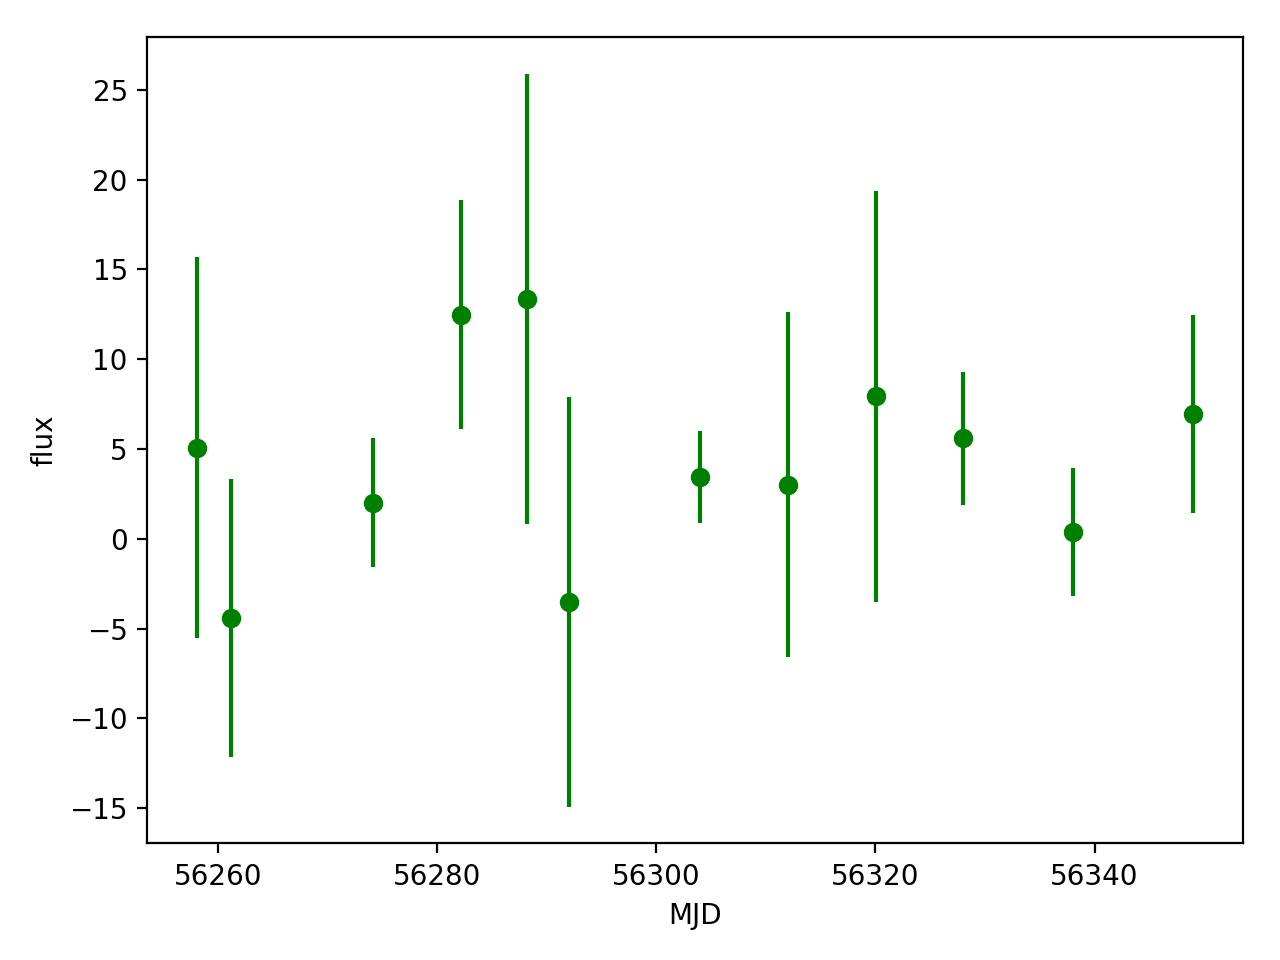

In [3]:
lc = pd.read_csv('training_set_for_LSST_DSFP/FAKE001.dat', delim_whitespace=True, comment = '#')

g_obs = np.where(lc['pb'] == 'g')

fig, ax = plt.subplots(figsize=(7,7))
ax.errorbar(lc['t'].iloc[g_obs].values, 
             lc['flux'].iloc[g_obs].values, 
             lc['dflux'].iloc[g_obs].values, 
             fmt = 'o', color = 'green')
ax.set_xlabel('MJD')
ax.set_ylabel('flux')
fig.tight_layout()

As we have many light curve files (in principle as many as 37 billion...), we will define a `Source()` class to ease our handling of the data.

**Problem 1b** 

Complete the plotting method in the `Source` class defined below.

*Hint* - a for loop can be helpful for dealing with the different filters

In [8]:
class Source():
    '''Astronomical source object for NOAO formatted light curve'''
    
    def __init__(self, filename):
        '''Read in light curve data'''
        lc_df = pd.read_csv(filename, delim_whitespace=True, comment = '#')
        u_obs = np.where(lc_df['pb'] == 'u')
        if len(u_obs[0]) > 0:
            lc_df.drop(lc_df.index[u_obs], inplace=True)
        self._lc_df = lc_df
        self._filename = filename
        self._filters = np.unique(self._lc_df['pb'])
        
    def plot_multicolor_lc(self):
        '''Plot the 4 band light curve'''
        fig, ax = plt.subplots(figsize=(7,7))
        color_dict = {'g': '#78A5A3', 
                      'r': '#CE5A57', 
                      'i': '#E1B16A', 
                      'z': '#444C5C', }
        
        for filt in self._filters:
            filt_obs = np.where(self._lc_df['pb'] == filt)
            color = color_dict[filt]
            exec('''{0} = ax.errorbar(self._lc_df['t'].iloc[filt_obs], 
                                      self._lc_df['flux'].iloc[filt_obs],
                                      self._lc_df['dflux'].iloc[filt_obs],
                                      fmt = 'o', color = '{1}', 
                                      label = "${0}$")'''.format(filt, color))
        ax.legend(fancybox = True)
        ax.set_xlabel(r"$\mathrm{MJD}$")
        ax.set_ylabel(r"$\mathrm{flux}$")
        fig.tight_layout()

**Problem 1c**

Confirm the corrections made in **1b** by plotting the multiband light curve for the source `FAKE010`.

<IPython.core.display.Javascript object>


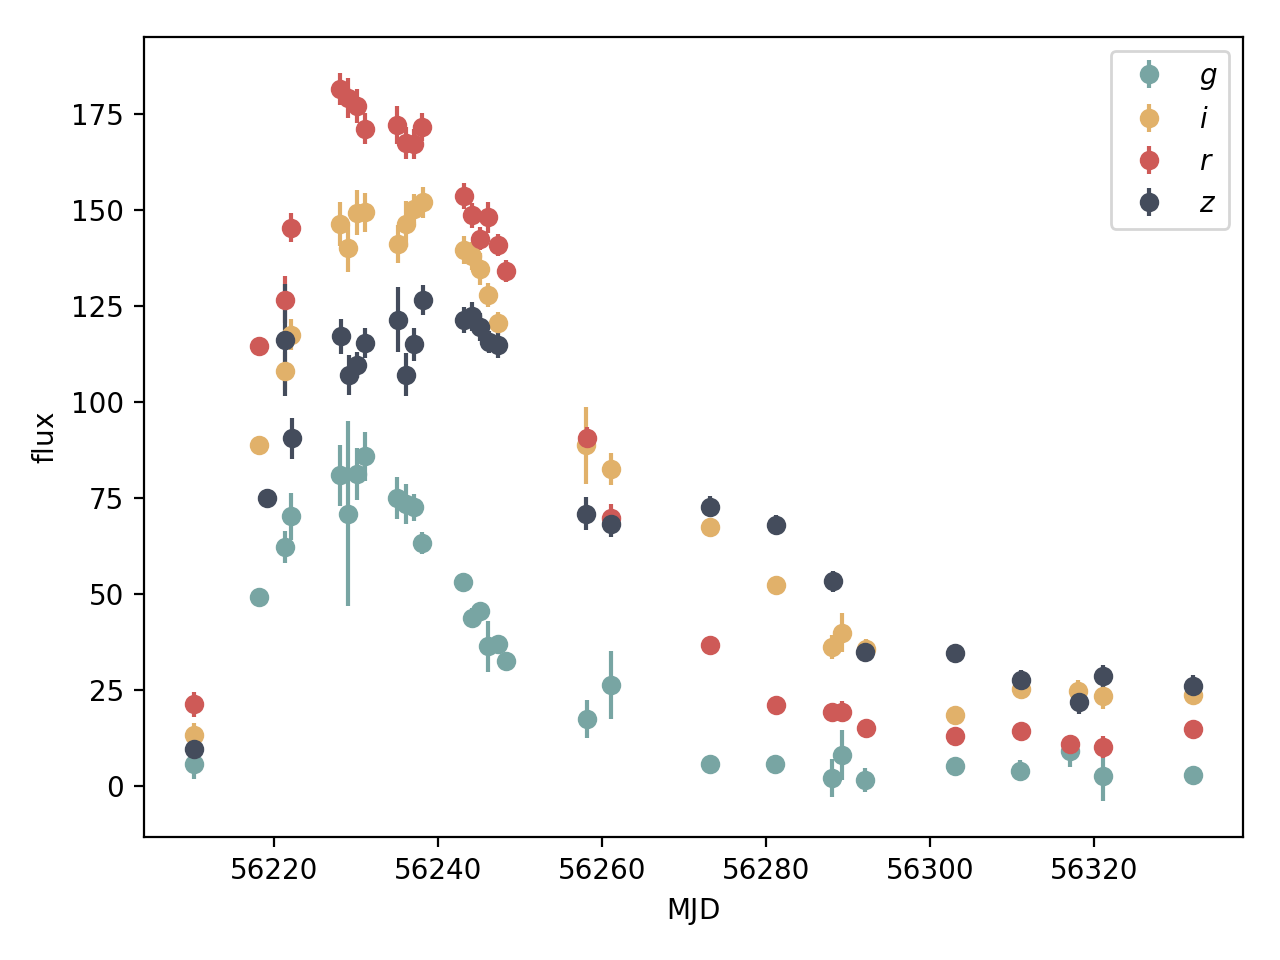

In [104]:
lc = Source('training_set_for_LSST_DSFP/FAKE010.dat')

lc.plot_multicolor_lc()

One thing that we brushed over previously is that the brightness measurements have units of flux, rather than the traditional use of magnitudes. The reason for this is that LSST will measure flux variations via image differencing, which will for some sources in some filters result in a measurement of *negative flux*. (You may have already noticed this in **1a**.) Statistically there is nothing wrong with such a measurement, but it is impossible to convert a negative flux into a magnitude. Thus we will use flux measurements throughout this exercise.

Using flux measurements will allow us to make unbiased measurements of the statistical distributions of the variations of the sources we care about. 

**Problem 1d**

What is `FAKE010` the source that is plotted above?

*Hint* - ask Griffin or Rob...

**Solution 1d**

`FAKE010` is a transient, as can be seen by the rapid rise followed by a gradual decline in the light curve. In this particular case, we can further guess that `FAKE010` is a Type Ia supernova due to the secondary maxima in the $i'$ and $z'$ light curves. These secondary peaks are not present in any other known type of transient.

**Problem 1e**

To get a better sense of the data, plot the multiband light curves for sources `FAKE060` and `FAKE095`.

<IPython.core.display.Javascript object>


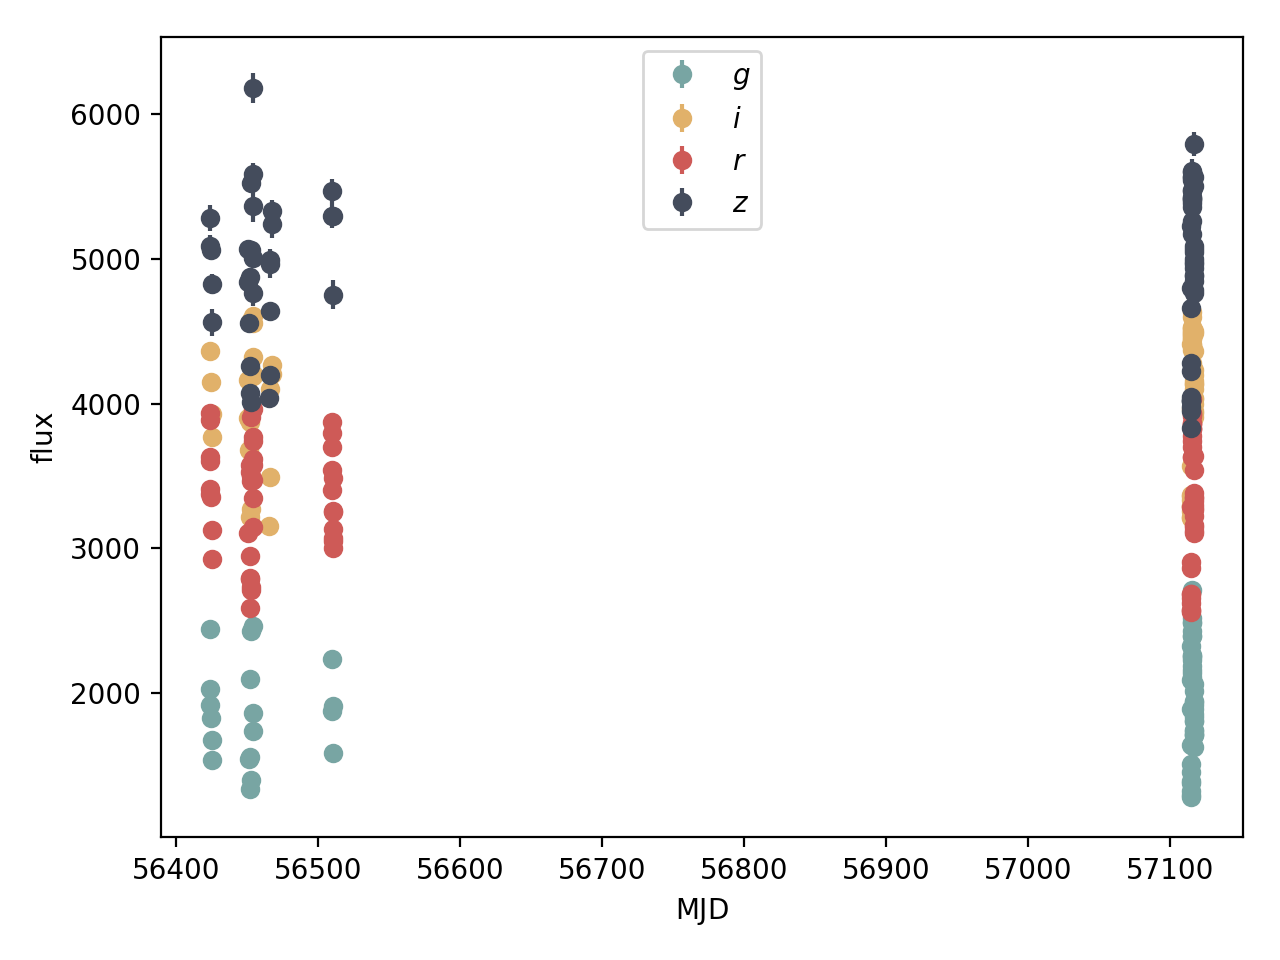

<IPython.core.display.Javascript object>


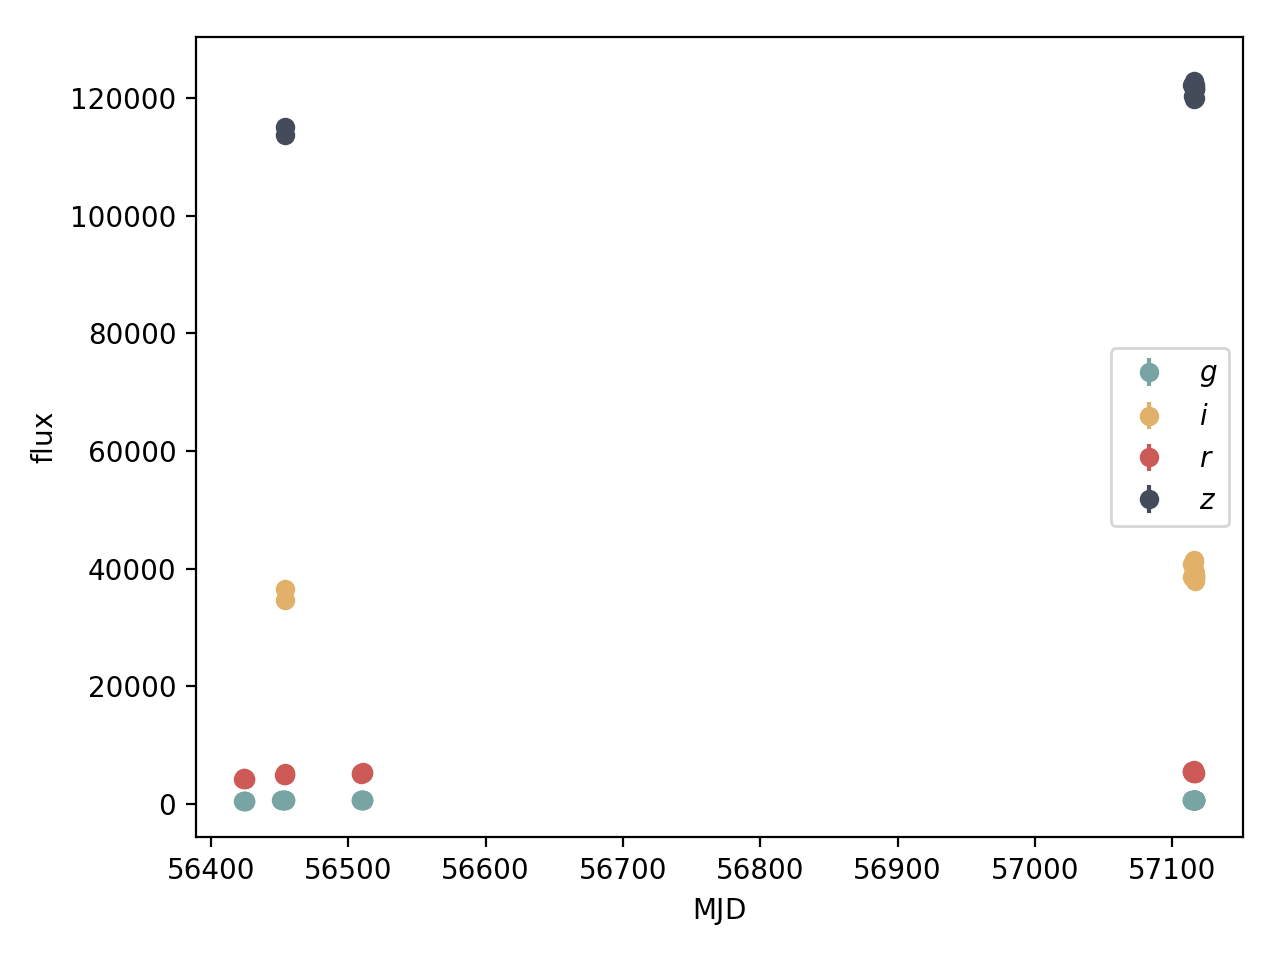

In [105]:
lc60 = Source("training_set_for_LSST_DSFP/FAKE060.dat")
lc60.plot_multicolor_lc()

lc95 = Source("training_set_for_LSST_DSFP/FAKE095.dat")
lc95.plot_multicolor_lc()

## Problem 2) Data Preparation

While we could create a database table that includes every single photometric measurement made by LSST, this ~37 trillion row db would be enormous without providing a lot of added value beyond the raw flux measurements [while this table is necessary, alternative tables may provide more useful information]. Furthermore, extracting individual light curves from such a database will be slow. Instead, we are going to develop summary statistics for every source which will make it easier to select individual sources and develop classifiers to identify objects of interest.  

Below we will create a new class, `Variable`, which will inherit the properties of the `Source` class. The `Variable` class includes several additional methods so we can (eventually) store summary statistics in a database table. In the interest of time, we limit the summary statistics to a relatively small list all of which have been shown to be useful for classification (see [Richards et al. 2011](http://iopscience.iop.org/article/10.1088/0004-637X/733/1/10/meta) for further details). The statistics that we include (for now) are: 

1. `Std` -- the standard deviation of the flux measurements 
2. `Amp` -- the amplitude of flux deviations
3. `MAD` -- the median absolute deviation of the flux measurements
4. `beyond1std` -- the fraction of flux measurements beyond 1 standard deviation
5. `skew` -- the skewness of a data set
6. the mean $g' - r'$, $r' - i'$, and $i' - z'$ color


*Note* - while the magnitude system used in astronomy is stupid, and as a reminder: 

$$\mathrm{mag} = -2.5\log{\mathrm{flux}} + C$$

where $C$ is a constant. Comparisons of $\Delta \mathrm{flux}$ for different stars encodes both the brightness variations *and* the distance to the star in question. $\Delta \mathrm{mag}$, on the other hand, normalizes the brightness variations to provide a more apples to apples comparison (however the use of a logarithmic basis results in a biased apples to apples comparison).

All of this is a long way of saying - when you calculate the `Std`, `Amp`, and `MAD` below you want to normalize these measurements by dividing each by the weighted mean of the flux in each filter.

**Problem 2a**

Create the `Variable` class, which should inherit the properties of the `Source` class. Include methods within the `Variable` class to calculate the 6 summary statistics listed above. Be sure to point to `Source` explicitly, and do not use the `super()` method that Jeff discussed previously (this matters later on).

*Hint* - use python [lambda functions](https://pythonspot.com/python-lambda/) to define the calculation, then loop over the filters. 1 example lambda function is given to calculate the weighted mean flux.

*Hint 2* - use [`scipy.stats.skew`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) to calculate the skew.

*food for thought* - if a source is observed in different filters but the observations are not simultaneous (or quasi-simultaneous), what is the meaning of a "mean color"?

*Solution to food for thought* - in this case we simply want you to take the mean flux in each filter and create a statistic that is $-2.5 \log \frac{\langle f_X \rangle}{\langle f_{Y} \rangle}$, where ${\langle f_{Y} \rangle}$ is the mean flux in band $Y$, while $\langle f_X \rangle$ is the mean flux in band $X$, which can be $g', r', i', z'$. Note that our use of image-difference flux measurements, which can be negative, means you'll need to add some form a case excpetion if $\langle f_X \rangle$ or $\langle f_Y \rangle$ is negative. In these cases set the color to -999.

In [63]:
class Variable(Source):
    '''Variable subclass of fake sources'''
    
    def __init__(self, filename):
        Source.__init__(self, filename)
    
    def filter_flux(self):
        '''Store individual passband fluxes as object attributes'''
        
        for filt in self._filters:
            filt_obs = np.where(self._lc_df['pb'] == filt)
            exec("self._{0}_time = self._lc_df['t'].iloc[filt_obs]".format(filt))
            exec("self._{0}_flux = self._lc_df['flux'].iloc[filt_obs]".format(filt))
            exec("self._{0}_flux_unc = self._lc_df['dflux'].iloc[filt_obs]".format(filt))

    def weighted_mean_flux(self):
        '''Measure (SNR weighted) mean flux in griz'''

        if not hasattr(self, '_g_flux'):
            self.filter_flux()
            
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        for filt in self._filters:
            exec("self._{0}_mean = weighted_mean(self._{0}_flux, self._{0}_flux_unc)".format(filt))
        
    def normalized_flux_std(self):
        '''Measure standard deviation of flux in griz'''

        if not hasattr(self, '_g_mean'):
            self.weighted_mean_flux()
        
        normalized_flux_std = lambda flux, w_mean_flux: np.std(flux/w_mean_flux, ddof = 1) 

        for filt in self._filters:
            exec("self._{0}_std = normalized_flux_std(self._{0}_flux, self._{0}_mean)".format(filt))

    def normalized_amplitude(self):
        '''Measure the normalized amplitude of variations in griz'''

        if not hasattr(self, '_g_mean'):
            self.weighted_mean_flux()

        normalized_amplitude = lambda flux, w_mean_flux: (np.max(flux) - np.min(flux))/w_mean_flux

        for filt in self._filters:
            exec("self._{0}_amp = normalized_amplitude(self._{0}_flux, self._{0}_mean)".format(filt))
        
    def normalized_MAD(self):
        '''Measure normalized Median Absolute Deviation (MAD) in griz'''

        if not hasattr(self, '_g_mean'):
            self.weighted_mean_flux()

        normalized_mad = lambda flux, w_mean_flux: np.median(np.abs((flux - np.median(flux))/w_mean_flux))
        
        for filt in self._filters:
            exec("self._{0}_mad = normalized_mad(self._{0}_flux, self._{0}_mean)".format(filt))
        
    def beyond_1std(self):
        '''Measure fraction of flux measurements beyond 1 std'''

        if not hasattr(self, '_g_mean'):
            self.weighted_mean_flux()
        
        beyond_1std = lambda flux, w_mean_flux: sum(np.abs(flux - w_mean_flux) > np.std(flux, ddof = 1))/len(flux)
        
        for filt in self._filters:
            exec("self._{0}_beyond = beyond_1std(self._{0}_flux, self._{0}_mean)".format(filt))
    
    def skew(self):
        '''Measure the skew of the flux measurements'''
            
        skew = lambda flux: spstat.skew(flux) 
        for filt in self._filters:
            exec("self._{0}_skew = skew(self._{0}_flux)".format(filt))
        
    def mean_colors(self):
        '''Measure the mean g-r, g-i, and g-z colors'''

        if not hasattr(self, '_g_mean'):
            self.weighted_mean_flux()
        
        for filt_pair in [('g','r'), ('r','i'), ('i','z')]:
            exec('self._{0}_minus_{1} = -2.5*np.log10(self._{0}_mean/self._{1}_mean) \
             if self._{0}_mean> 0 and self._{1}_mean > 0 else -999'.format(filt_pair[0], filt_pair[1]))

**Problem 2b**

Confirm your solution to **2a** by measuring the mean colors of source `FAKE010`. Does your measurement make sense given the plot you made in **1c**?

In [44]:
var = Variable('training_set_for_LSST_DSFP/FAKE010.dat')
var.mean_colors()

print("The g'-r', r'-i', and 'i-z' colors are:\
    {:.3f}, {:.3f}, and {:.3f}, respectively.". format(var._g_minus_r, var._r_minus_i, var._i_minus_z))

The g'-r', r'-i', and 'i-z' colors are:    1.048, -0.191, and -0.193, respectively.


## Problem 3) Store the sources in a database

Building (and managing) a database from scratch is a challenging task. For (very) small projects one solution to this problem is to use [`SQLite`](http://sqlite.org/), which is a self-contained, publicly available SQL engine. One of the primary advantages of `SQLite` is that no server setup is required, unlike other popular tools such as postgres and MySQL. In fact, `SQLite` is already integrated with python so everything we want to do (create database, add tables, load data, write queries, etc.) can be done within Python.

Without diving too deep into the details, here are situations where `SQLite` has advantages and disadvantages [according to their own documentation](http://sqlite.org/whentouse.html):

*Advantages*

1. Situations where expert human support is not needed
2. For basic data analysis (`SQLite` is easy to install and manage for new projects)
3. Education and training

*Disadvantages*

1. Client/Server applications (`SQLite` does not behave well if multiple systems need to access db at the same time)
2. Very large data sets (`SQLite` stores entire db in a single disk file, other solutions can store data across multiple files/volumes)
3. High concurrency (Only 1 writer allowed at a time for `SQLite`)

From the (limited) lists above, you can see that while `SQLite` is perfect for our application right now, if you were building an actual ANTARES-like system a more sophisticated database solution would be required.  

**Problem 3a**

Import sqlite3 into the notebook. 

*Hint* - if this doesn't work, you may need to run 

`conda install sqlite3`

within your `IDEAS` conda environment.

In [24]:
import sqlite3

Following the `sqlite3` import, we must first connect to the database. If we attempt a connection to a database that does not exist, then a new database is automatically created. Here we will create a new database file, called `MiniBroker.db`.

In [25]:
conn = sqlite3.connect("MiniBroker.db")

We now have a database connection object, `conn`. To interact with the database (create tables, load data, write queries) we need a cursor object.

In [26]:
cur = conn.cursor()

Now that we have a cursor object, we can populate the database. As an example we will start by creating a table to hold all the raw photometry (though ultimately we will not use this table for analysis).

*Note* - there are many cursor methods capable of interacting with the database. The most common, [`execute`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.execute), takes a single `SQL` command as its argument and executes that command. Other useful methods include [`executemany`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.executemany), which is useful for inserting data into the database, and [`executescript`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.executescript), which take an `SQL` script as its argument and executes the script.

In many cases, as below, it will be useful to use triple quotes in order to improve the legibility of your code.

In [27]:
cur.execute("""drop table if exists rawPhot""") # drop the table if is already exists
cur.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
""")

Let's unpack everything that happened in these two commands. First - if the table `rawPhot` already exists, we drop it to start over from scratch. (this is useful here, but should not be adopted as general practice)

Second - we create the new table `rawPhot`, which has 6 columns: `id` - a running index for every row in the table, `objId` - an ID to identify which source the row belongs to, `t` - the time of observation in MJD, `pb` - the passband of the observation, `flux` the observation flux, and `dflux` the uncertainty on the flux measurement. In addition to naming the columns, we also must declare their type. We have declared `id` as the primary key, which means this value will automatically be assigned and incremented for all data inserted into the database. We have also declared `pb` as a variable character of length 1, which is more useful and restrictive than simply declaring `pb` as `text`, which allows any freeform string.

Now we need to insert the raw flux measurements into the database. To do so, we will use the `BrokerLc` class that we created earlier. As an initial example, we will insert the first 3 observations from the source `FAKE010`.

In [30]:
filename = "training_set_for_LSST_DSFP/FAKE001.dat"
var = Variable(filename)

objId = int(filename.split('FAKE')[1].split(".dat")[0])

cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(var._lc_df.iloc[0])))
cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(var._lc_df.iloc[1])))
cur.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(var._lc_df.iloc[2])))

There are two things to highlight above: (1) we do not specify an id for the data as this is automatically generated, and (2) the data insertion happens via a tuple. In this case, we are taking advantage of the fact that a Python tuple can be concatenated:

    (objId,) + tuple(lc10.DFlc.ix[0]))
    
While the above example demonstrates the insertion of a single row to the database, it is far more efficient to bulk load the data. To do so we will delete, i.e. `DROP`, the rawPhot table and use some `pandas` manipulation to load the contents of an entire file at once via [`executemany`](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.executemany).

In [31]:
cur.execute("""drop table if exists rawPhot""") # drop the table if it already exists
cur.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
""")

# next 3 lines are already in name space; repeated for clarity
filename = "training_set_for_LSST_DSFP/FAKE001.dat"
var = Variable(filename)

objId = int(filename.split('FAKE')[1].split(".dat")[0])

data = [(objId,) + tuple(x) for x in var._lc_df.values] # array of tuples

cur.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

Load all of the raw photometric observations into the `rawPhot` table in the database.

**Problem 3b**
Load all of the raw photometric observations into the `rawPhot` table in the database. 

*Hint* - you can use [`glob`](https://docs.python.org/3/library/glob.html) to select all of the files being loaded.

*Hint 2* - you have already loaded the data from `FAKE001` into the table.

In [32]:
# build your list of filenames here
import glob
filenames = glob.glob("training_set_for_LSST_DSFP/FAKE*.dat")

for filename in filenames[1:]: 
    var = Variable(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])

    data = [(objId,) + tuple(x) for x in var._lc_df.values] # array of tuples

    cur.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

**Problem 3c**

To ensure the data have been loaded properly, select the $g'$ light curve for source `FAKE010` from the `rawPhot` table and plot the results. Does it match the plot from **1c**?

<IPython.core.display.Javascript object>


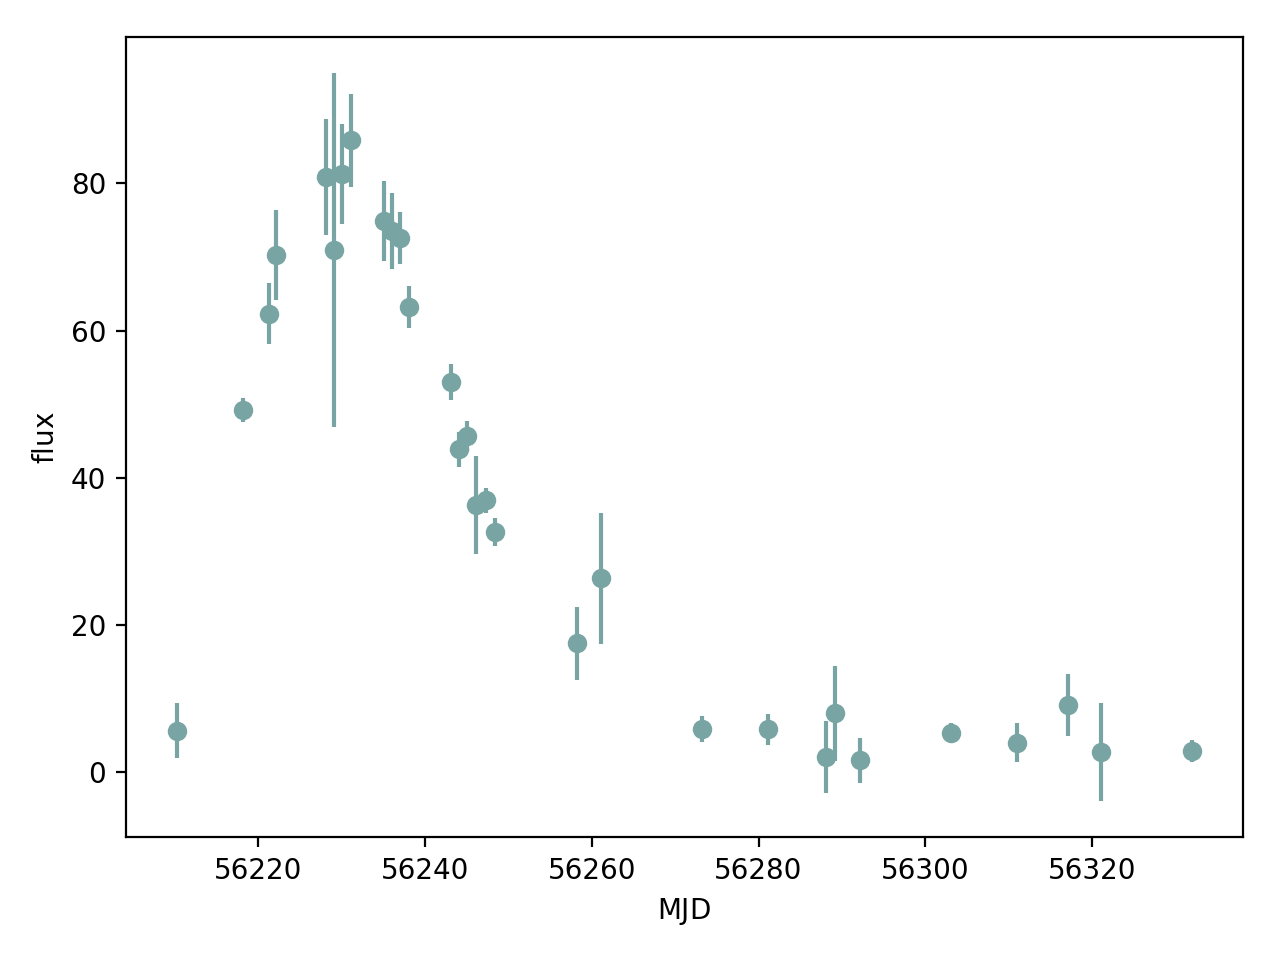

In [33]:
cur.execute("""select t, flux, dflux 
               from rawPhot
               where objId = 10 and pb = 'g'""")

data = cur.fetchall()
data = np.array(data)

fig, ax = plt.subplots(figsizplt.subplots()e=(7,7))
ax.errorbar(data[:,0], data[:,1], data[:,2], fmt = 'o', color = '#78A5A3')
ax.set_xlabel(r"$\mathrm{MJD}$")
ax.set_ylabel(r"$\mathrm{flux}$")
fig.tight_layout()

While we cannot load the light curves to the database in parallel, using the concept of [MapReduce](https://en.wikipedia.org/wiki/MapReduce) we can use the iPython "cluster" that we created to map the I/O process (typically lots of overhead) to multiple machines, and then we can reduce their output to a single object to be loaded into the database. 

Of course, *before you parallelize, you profile*.

**Problem 3d**

Earlier it was claimed that bulk loading the data is faster than loading it line by line. Prove this assertion, use `%%timeit` to "profile" the two different options (bulk load with `executemany` and loading one photometric measurement at a time via for loop).

Compare both serial solutions, to load the data in parallel.

*Hint* - to avoid corruption of your current working database, `MiniBroker.db`, create temporary databases for the pupose of running this test. Note - the creation and connection to the database should happen outside your `%%timeit` magic function. This means your solution will have (at least) 4 separate cells.

In [34]:
tmp_conn1 = sqlite3.connect("tmp1.db")
tmp_cur1 = tmp_conn1.cursor()

tmp_cur1.execute("""drop table if exists rawPhot""") # drop the table if it already exists
tmp_cur1.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
                """)

In [35]:
%%timeit
# time how long it takes to load every observation individually


for filename in filenames: 
    var = Variable(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])

    for obs in var._lc_df.values:
        tmp_cur1.execute("""insert into rawPhot(objId, t, pb, flux, dflux) values {}""".format((objId,) + tuple(obs)))

481 ms ± 57.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
tmp_conn2 = sqlite3.connect("tmp2.db")
tmp_cur2 = tmp_conn2.cursor()

tmp_cur2.execute("""drop table if exists rawPhot""") # drop the table if it already exists
tmp_cur2.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
                """)

In [37]:
%%timeit
# time how long it takes to load all observations of a single source at once


for filename in filenames: 
    var = Variable(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])

    data = [(objId,) + tuple(x) for x in var._lc_df.values] # array of tuples

    tmp_cur2.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

261 ms ± 28.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


You shold have confirmed that loading a full light curve is faster than loading individual observations (not by a ton, but faster is faster and microseconds count when you are dealing with 37 billion sources).

Now we will parallelize this operation in order to perform the I/O in parallel, followed by a single bulk load of the data. To do so, we need the `@require` decorator, which will ensure the necessary packages and definitions are available on each computer within our cluster.

In [47]:
# execute this
@require(Source, Variable, 'pandas as pd', 'numpy as np')
def load_data(filename):
    var = Variable(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])
    data = [(objId,) + tuple(x) for x in var._lc_df.values] # array of tuples
    return data

Now, we use the previously defined `lview` variable to achieve `DirectView` access to the cluster to map the `load_data` function on to all the filenames, and get the results.

In [48]:
result = lview.map(load_data, filenames)
all_data = result.get()

And now that you have results, drop the `rawPhot` table if it already exists, and load the observations into the database as before.

In [49]:
cur.execute("""drop table if exists rawPhot""") # drop the table if it already exists
cur.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
                """)

for data in all_data: 
    cur.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

**Problem 3e** Confirm that reading the data in parallel is faster than the seriel operations in **3d** using the `%%timeit` function as before.

In [50]:
tmp_conn3 = sqlite3.connect("tmp3.db")
tmp_cur3 = tmp_conn3.cursor()

tmp_cur3.execute("""drop table if exists rawPhot""") # drop the table if it already exists
tmp_cur3.execute("""create table rawPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
                """)

In [51]:
%%timeit
# time how long it takes to read files in parallel

result = lview.map(load_data, filenames)
all_data = result.get()

for data in all_data: 
    tmp_cur3.executemany("""insert into rawPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

96.7 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That isn't quite a factor of 4x speed up, but it represents a significant improvement, and recall that writing to the database must happen as a serial process because we are using `SQLite`.

**Problem 3f**

Once again -- ensure the data have been loaded properly by plotting the $g'$ light curve for source `FAKE010` from the `rawPhot` table and plot the results. Does it match your earlier plots?

<IPython.core.display.Javascript object>


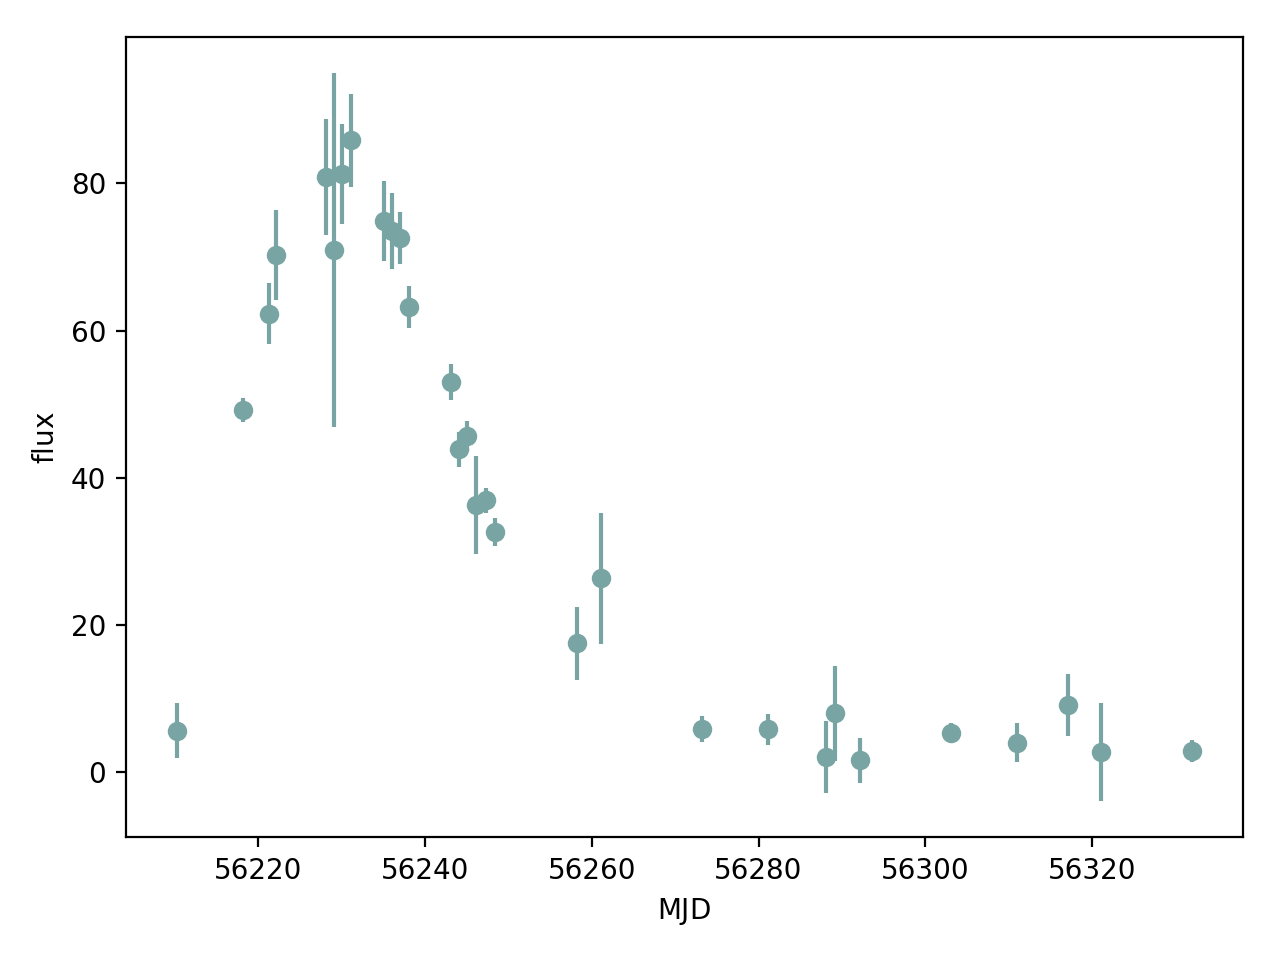

In [52]:
cur.execute("""select t, flux, dflux 
               from rawPhot
               where objId = 10 and pb = 'g'""")

data = cur.fetchall()
data = np.array(data)

fig, ax = plt.subplots(figsize=(7,7))
ax.errorbar(data[:,0], data[:,1], data[:,2], fmt = 'o', color = '#78A5A3')
ax.set_xlabel(r"$\mathrm{MJD}$")
ax.set_ylabel(r"$\mathrm{flux}$")
fig.tight_layout()

### Problem 3) Part 2 -- Calculate and store the features in the same database

Now that we have loaded the raw observations, we need to create a new table to store summary statistics for each object. This table will include the `Variable` class attributes. 

In [54]:
cur.execute("""drop table if exists lcFeats""") # drop the table if it already exists
cur.execute("""create table lcFeats(
                id integer primary key,
                objId int,
                gStd float,
                rStd float,
                iStd float,
                zStd float,
                gAmp float, 
                rAmp float, 
                iAmp float, 
                zAmp float, 
                gMAD float,
                rMAD float,
                iMAD float,                
                zMAD float,                
                gBeyond float,
                rBeyond float,
                iBeyond float,
                zBeyond float,
                gSkew float,
                rSkew float,
                iSkew float,
                zSkew float,
                gMinusR float,
                rMinusI float,
                iMinusZ float,
                FOREIGN KEY(objId) REFERENCES rawPhot(objId)
                ) 
""")

The above procedure should look familiar to above, with one exception: the addition of the `foreign key` in the `lcFeats` table. The inclusion of the `foreign key` ensures a connected relationship between `rawPhot` and `lcFeats`. In brief, a row cannot be inserted into `lcFeats` unless a corresponding row, i.e. `objId`, exists in `rawPhot`. Additionally, rows in `rawPhot` cannot be deleted if there are dependent rows in `lcFeats`. 

**Problem 3g**

In parallel - calculate all the `BrokerLc` features for every source in `rawPhot`. Then, bulkload these features into the `lcFeats` table. Use the same map reduce procedure as above. When calculating the features create a tuple called `feats` with entries corresponding to the `lcFeats` table, *in the exact order of the columns in that table*. 

*Hint* - it might be easier to write a seriel solution first and then introduce the `DirectView` implemenation. Feature calculation requires significant resources, so accomplishing this in parallel will save lots of time.

*Hint 2* - technically, LSST light curves will be "generated" from the `rawPhot` table. However, skip that step for now as the `BrokerLc` class reads in data from a file, so loop over those files to populate the `lcFeats` table.

In [70]:
# as before, define a function to calculate the features for one lightcurve

@require(Source, Variable, 'pandas as pd', 'numpy as np', 'scipy.stats as spstat')
def calculate_features(filename):
    var = Variable(filename)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])
    var.weighted_mean_flux()
    var.normalized_flux_std()
    var.normalized_amplitude()
    var.normalized_MAD()
    var.beyond_1std()
    var.skew()
    var.mean_colors()
    feats = (objId, var._g_std, var._r_std, var._i_std, var._z_std, 
            var._g_amp,  var._r_amp,  var._i_amp,  var._z_amp,  
            var._g_mad, var._r_mad, var._i_mad, var._z_mad, 
            var._g_beyond, var._r_beyond, var._i_beyond, var._z_beyond,
            var._g_skew, var._r_skew, var._i_skew, var._z_skew, 
            var._g_minus_r, var._r_minus_i, var._i_minus_z)
    return feats

In [71]:
# and then lets map the function onto all the data
result = lview.map(calculate_features, filenames)

# and get the result
all_feats = result.get()

# and now load it all into our table
for feats in all_feats:
    cur.execute("""insert into lcFeats(objId, 
                                       gStd, rStd, iStd, zStd, 
                                       gAmp,  rAmp,  iAmp,  zAmp,  
                                       gMAD, rMAD, iMAD, zMAD, 
                                       gBeyond, rBeyond, iBeyond, zBeyond,
                                       gSkew, rSkew, iSkew, zSkew,
                                       gMinusR, rMinusI, iMinusZ) values {}""".format(feats))

**Problem 3h**

Confirm that the data loaded correctly by counting the number of sources with `gAmp` > 2.

How many sources have `gMinusR` = -999?

*Hint* - you should find 9 and 2, respectively.

In [72]:
cur.execute("""select count(*) from lcFeats where gAmp > 2""")

nAmp2 = cur.fetchone()[0]

cur.execute("""select count(*) from lcFeats where gMinusR = -999""")
nNoColor = cur.fetchone()[0]

print("There are {:d} sources with gAmp > 2".format(nAmp2))
print("There are {:d} sources with no measured i' - z' color".format(nNoColor))

There are 9 sources with gAmp > 2
There are 2 sources with no measured i' - z' color


Finally, we close by commiting the changes we made to the database.

Note that strictly speaking this is not needed, however, were we to update any values in the database then we would need to commit those changes.

In [73]:
conn.commit()

## Problem 4) Build a Classification Model

One of the primary goals for LSST Brokers is to separate the Wheat from the Chaff. In other words, given that ~10 million alerts will be issued by LSST on a nightly basis, what is the single (or 10, or 100) most interesting alerts.

Here we will build on the skills developed during the previous homework to construct a machine-learning model to classify new light curves. 

Fortunately - the data that has already been loaded to MiniBroker.db is a suitable training set for the classifier (we simply haven't provided you with labels just yet). Execute the cell below to add a new table to the database which includes the appropriate labels.

In [74]:
cur.execute("""drop table if exists lcLabels""") # drop the table if it already exists
cur.execute("""create table lcLabels(
               objId int,
               label int, 
               foreign key(objId) references rawPhot(objId)
               )""")

labels = np.zeros(100)
labels[20:60] = 1
labels[60:] = 2

data = np.append(np.arange(1,101)[np.newaxis].T, labels[np.newaxis].T, axis = 1)
tup_data = [tuple(x) for x in data]

cur.executemany("""insert into lcLabels(objId, label) values (?,?)""", tup_data)

For now - don't worry about what the labels mean (though if you inspect the light curves you may be able to figure this out...)

**Problem 4a**

Query the database to select features and labels for the light curves in your training set. Store the results of these queries in `numpy` arrays, `X` and `y`, respectively, which are suitable for the various `scikit-learn` machine learning algorithms.

*Hint* - recall that databases do not store ordered results.

*Hint 2* - recall that `scikit-learn` expects `y` to be a 1d array. You will likely need to convert a 2d array to 1d. 

In [75]:
cur.execute("""select label
               from lcLabels 
               order by objId asc""")
y = np.array(cur.fetchall()).ravel()

cur.execute("""select gStd, rStd, iStd, zStd, 
                      gAmp,  rAmp,  iAmp,  zAmp,  
                      gMAD, rMAD, iMAD, zMAD, 
                      gBeyond, rBeyond, iBeyond, zBeyond,
                      gSkew, rSkew, iSkew, zSkew,
                      gMinusR, rMinusI, iMinusZ
               from lcFeats
               order by objId asc""")
X = np.array(cur.fetchall())

**Problem 4b**

Train a SVM model ([`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) in `scikit-learn`) using a radial basis function (RBF) kernel with penalty parameter, $C = 1$, and kernel coefficient, $\gamma = 0.1$.

Evaluate the accuracy of the model via $k = 5$ fold cross validation. 

*Hint* - you may find the [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) module helpful.

In [76]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(SVC(C = 1.0, gamma = 0.1, kernel = 'rbf'), X, y, cv = 5)

print("The SVM model produces a CV accuracy of {:.4f}".format(np.mean(cv_scores)))

The SVM model produces a CV accuracy of 0.8600


The SVM model does a decent job of classifying the data. However - we are going to have 10 million alerts every night. Therefore, we need something that runs quickly. For most ML models the training step is slow, while predictions are (relatively) fast. 

**Problem 4c**

Pick any other [classification model from `scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html), and "profile" the time it takes to train that model vs. the time it takes to train an SVM model (by using the `%%timeit` magic function).

Is the model that you have selected faster than SVM?

*Hint* - you should import the model outside your timing loop as we only care about the training step in this case.

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=25)
svm_clf = SVC(C = 1.0, gamma = 0.1, kernel = 'rbf')

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [78]:
%%timeit
# timing solution for RF model
rf_clf.fit(X,y)

20 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
%%timeit
# timing solution for SVM model
svm_clf.fit(X,y)

529 µs ± 47.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Problem 4d**

Does the model you selected perform better than the SVM model? Perform a $k = 5$ fold cross validation to determine which model provides superior accuracy.

In [80]:
cv_scores = cross_val_score(rf_clf, X, y, cv = 5)

print("The RF model produces a CV accuracy of {:.4f}".format(np.mean(cv_scores)))

The RF model produces a CV accuracy of 0.8700


**Problem 4e**

Which model are you going to use in your Broker? Justify your answer. 

*Write solution to **4e** here*

In this case we are going to adopt the SVM model as it is a factor of 25 times faster than RF, while providing nearly identical performance from an accuracy stand point.

## Problem 5) Class Predictions for New Sources

Now that we have developed a basic infrastructure for dealing with streaming data, we may reap the rewards of our efforts. We will use our ANTARES-like software to classify newly observed sources.

**Problem 5a**

Load the light curves for the new observations (found in `full_testset_for_LSST_DSFP`) into the a table in the database. 

*Hint* - ultimately it doesn't matter much one way or another, but you may choose to keep new observations in a table separate from the training data. I put these observations into a new `testPhot` database. Up to you.

In [81]:
cur.execute("""drop table if exists testPhot""") # drop the table if is already exists
cur.execute("""create table testPhot(
                id integer primary key,
                objId int,
                t float, 
                pb varchar(1),
                flux float,
                dflux float) 
""")
cur.execute("""drop table if exists testFeats""") # drop the table if it already exists
cur.execute("""create table testFeats(
                id integer primary key,
                objId int,
                gStd float,
                rStd float,
                iStd float,
                zStd float,
                gAmp float, 
                rAmp float, 
                iAmp float, 
                zAmp float, 
                gMAD float,
                rMAD float,
                iMAD float,                
                zMAD float,                
                gBeyond float,
                rBeyond float,
                iBeyond float,
                zBeyond float,
                gSkew float,
                rSkew float,
                iSkew float,
                zSkew float,
                gMinusR float,
                rMinusI float,
                iMinusZ float,
                FOREIGN KEY(objId) REFERENCES testPhot(objId)
                ) 
""")

In [82]:
new_obs_filenames = glob.glob("test_set_for_LSST_DSFP/FAKE*.dat")

result = lview.map(load_data, new_obs_filenames)
all_data = result.get()

In [83]:
for data in all_data: 
    cur.executemany("""insert into testPhot(objId, t, pb, flux, dflux) values (?,?,?,?,?)""", data)

**Problem 5b**

Calculate features for the new observations and insert those features into a database table.

*Hint* - again, you may want to create a new table for this, up to you. I'm using the `testFeats` table.

In [84]:
result = lview.map(calculate_features, new_obs_filenames)
all_feats = result.get()

In [85]:
for feats in all_feats: 
    cur.execute("""insert into testFeats(objId, 
                                   gStd, rStd, iStd, zStd, 
                                   gAmp,  rAmp,  iAmp,  zAmp,  
                                   gMAD, rMAD, iMAD, zMAD, 
                                   gBeyond, rBeyond, iBeyond, zBeyond,
                                   gSkew, rSkew, iSkew, zSkew,
                                   gMinusR, rMinusI, iMinusZ) values {}""".format(feats))

**Problem 5c**

Train the model that you adopted in **4e** on the training set, and produce predictions for the newly observed sources.

What is the class distribution for the newly detected sources?

*Hint* - the training set was constructed to have a nearly uniform class distribution, that may not be the case for the actual observed distribution of sources.

In [86]:
svm_clf = SVC(C=1.0, gamma = 0.1, kernel = 'rbf').fit(X, y)

cur.execute("""select gStd, rStd, iStd, zStd, 
                      gAmp,  rAmp,  iAmp,  zAmp,  
                      gMAD, rMAD, iMAD, zMAD, 
                      gBeyond, rBeyond, iBeyond, zBeyond,
                      gSkew, rSkew, iSkew, zSkew,
                      gMinusR, rMinusI, iMinusZ
               from testFeats
               order by objId asc""")
X_new = np.array(cur.fetchall())

y_preds = svm_clf.predict(X_new)

print("""There are {:d}, {:d}, and {:d} sources 
         in classes 1, 2, 3, respectively""".format(*list(np.bincount(y_preds)))) # be careful using bincount

There are 3273, 502, and 1225 sources 
         in classes 1, 2, 3, respectively


It turns out that the classification performance in this case isn't particularly good. 

For the test set, the actual class labels were sneakily hidden in the file headers, and if you execute the cell below you will discover how many sources are in each class.

In [87]:
 ! grep label test_set_for_LSST_DSFP/*dat | sed -e 's/label:/ /' | awk '{print $2+1}' | sort | uniq -c

3403 1
  90 2
1507 3


As we discussed in the lecture, one challenge for this is problem is that individual observations are largely spaced out, and have very large uncertainties. The features that we have currently adopted (which are really just moments of the flux distribution) aren't robust to outliers, and are subject to the precise cadence of the observations.

One way to "correct" for the observational gaps and heteroskedastic uncertainties is to interpolate a model between the observations. A method that has become really popular recently is the use of Gaussian process regression (there will be more along these lines in the next homework assignment, but here we will provide a preview).

In [88]:
import sklearn.gaussian_process as gp

In [93]:
# we'll create a function that just fits the g band lightcurve
def calculate_gpfit(filename):
    """
    Do a quick gaussian process regression of just g-band lightcurve to get a smooth representation
    This should be more robust to outliers
    """
    var = Variable(filename)
    var.filter_flux()
    t = var._g_time.values
    y = var._g_flux.values
    dy = var._g_flux_unc.values
    t = t.reshape(-1, 1)
    objId = int(filename.split('FAKE')[1].split(".dat")[0])
    
    # a Gaussian Process is defined by a correlation function that relates each point to each other
    # I've chosen a simple common kernel - the Matern kernel. 
    # It has a nice property in that it is 'stationary' - the covariance between points 
    # only depends on their separation
    
    base_kernel = gp.kernels.Matern(length_scale=10.,nu=2.5, length_scale_bounds=(1.,20.))
    gkernel = 0.5*(np.median(dy)**2.)*base_kernel
    
    # the second thing you need to define a Gaussian Process is a mean function, which in our case is 
    # implictly zero (this is fine for transients - they spend most of eternity at the background!)
    gband = gp.GaussianProcessRegressor(kernel=gkernel, alpha=dy**2.).fit(t, y)
    
    # now lets use the Gaussian process to predict the lightcurve on an evenly sampled grid
    # this is appropriate for Wavelets, or generally robust feature extraction
    
    newtime = np.linspace(t.min(), t.max(), 200, endpoint=True)
    newtime = newtime.reshape(-1, 1)
    gnew = gband.predict(newtime, return_std=True)
    return (t, y , dy, newtime, gnew)

Lets look at one fit to see what's happening:

<IPython.core.display.Javascript object>


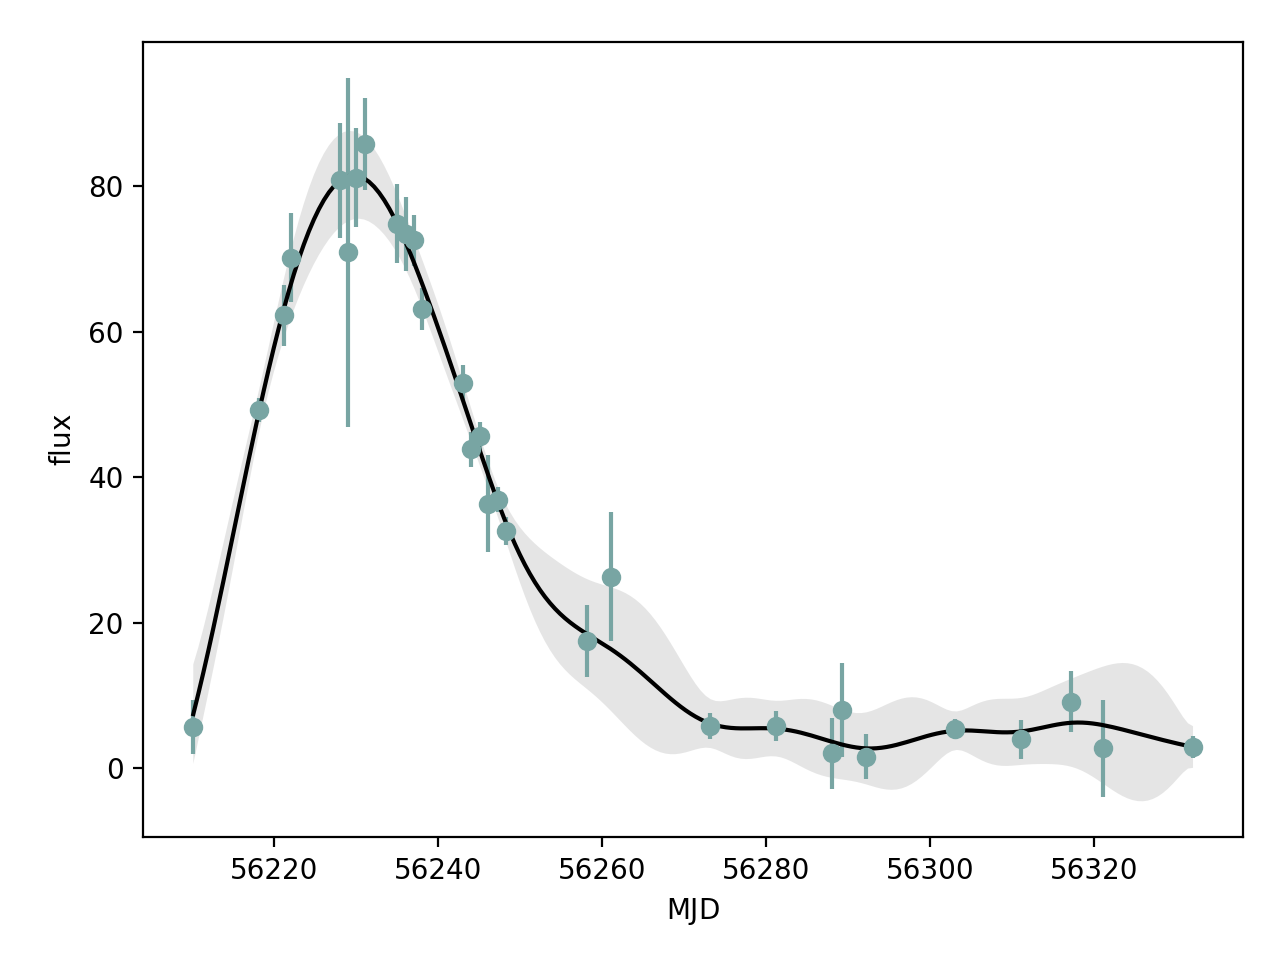

In [94]:
ftest = filenames[0:20]
gtime, gflux, gdflux, gnewtime, gnewflux = calculate_gpfit(ftest[6])

fig, ax = plt.subplots(figsize=(7,7))
ax.errorbar(gtime, gflux, gdflux, fmt = 'o', color = '#78A5A3')
ax.plot(gnewtime, gnewflux[0], 'k-')
ax.fill(np.concatenate([gnewtime, gnewtime[::-1]]),
        np.concatenate([gnewflux[0] - 1.9600 * gnewflux[1],
                        (gnewflux[0] + 1.9600 * gnewflux[1])[::-1]]),
         alpha=.5, fc='0.8', ec='None', label='95% confidence interval')
ax.set_xlabel(r"$\mathrm{MJD}$")
ax.set_ylabel(r"$\mathrm{flux}$")
fig.tight_layout()

Not only does GP regression provide an interpolation between observations, but it returns an uncertainty about that interpolation as well. Thus, it's possible to measure features on interpolated light curves that are observed with precisely the same cadence for all sources.

But here's the rub - can we practically run this on 10^4--5 alerts every 37 seconds for LSST?

This is one reason parallelization is so important - as long as we have enough computers, we can easily keep up with the LSST data rate even with complex features (e.g., periodicity search, GP regression, etc).

## Problem 6) Anomaly Detection

As we learned earlier - one of the primary goals of LSST brokers is to reduce the stream of 10 million alerts on any given night to the single (or 10, or 100) most interesting objects. One possible definition of "interesting" is rarity - in which case it would be useful to add some form of anomaly detection to the pipeline. `scikit-learn` has [several different algorithms](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#sphx-glr-auto-examples-covariance-plot-outlier-detection-py) that can be used for anomaly detection. Here we will employ [isolation forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) which has many parallels to random forests, which we have previously learned about.

In brief, isolation forest builds an ensemble of decision trees where the splitting parameter in each node of the tree is selected randomly. In each tree the number of branches necessary to isolate each source is measured - outlier sources will, on average, require fewer splittings to be isolated than sources in high-density regions of the feature space. Averaging the number of branchings over many trees results in a relative ranking of the anomalousness (*yes, I just made up a word*) of each source.

**Problem 6a**

Using [`IsolationForest`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) in `sklearn.ensemble` - determine the 10 most isolated sources in the data set.

*Hint* - for `IsolationForest` you will want to use the `decision_function()` method rather than `predict_proba()`, which is what we have previously used with `sklearn.ensemble` models to get relative rankings from the model.

In [100]:
from sklearn.ensemble import IsolationForest

isoF_clf = IsolationForest(n_estimators = 100, contamination=0.01)
isoF_clf.fit(X_new)
anomaly_score = isoF_clf.decision_function(X_new)

print("The 10 most anomalous sources are: {}".format(np.arange(1,5001)[np.argsort(anomaly_score)[:10]]))

The 10 most anomalous sources are: [ 491 2047  560 3797  864 1592 1706 4204 2768 1206]


/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


**Problem 6b**

Plot the light curves of the 2 most anomalous sources. 

Can you identify why these sources have been selected as outliers? Are these sources in fact outliers?

<IPython.core.display.Javascript object>


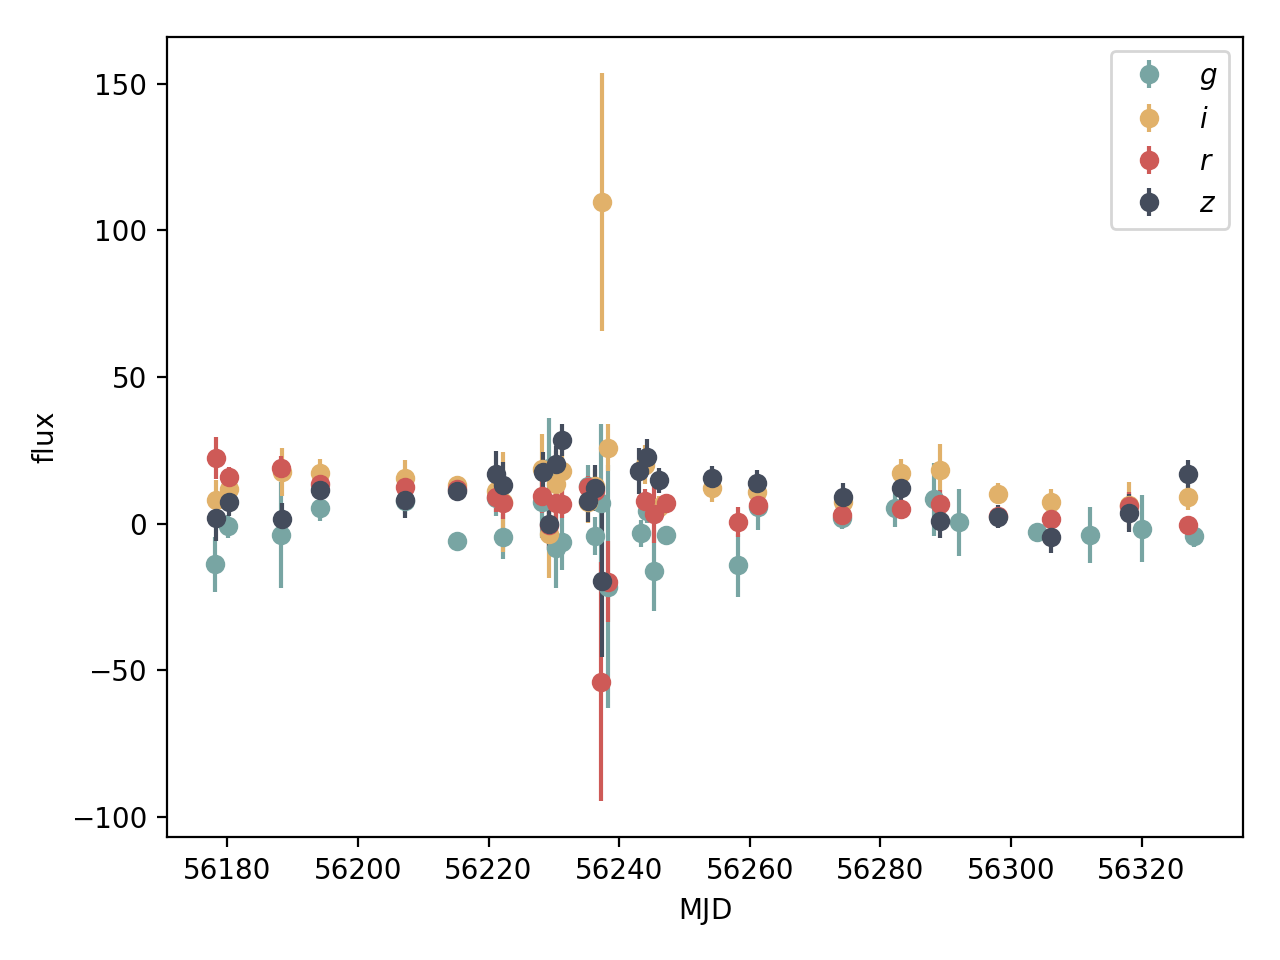

<IPython.core.display.Javascript object>


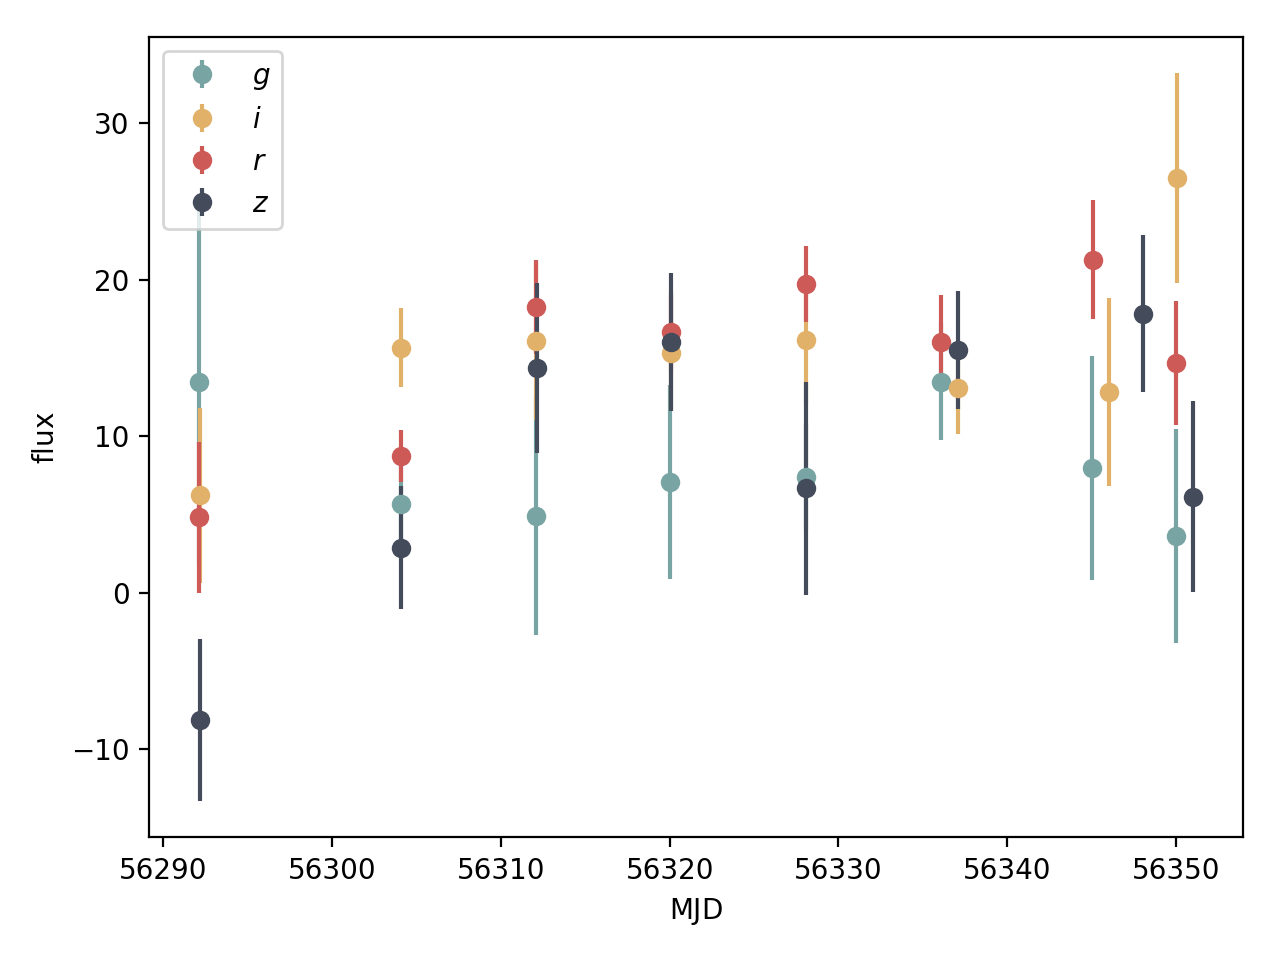

In [101]:
lc491 = BrokerLc("test_set_for_LSST_DSFP/FAKE00491.dat")
lc491.plot_multicolor_lc()

lc2047 = BrokerLc("test_set_for_LSST_DSFP/FAKE02030.dat")
lc2047.plot_multicolor_lc()

*Write solution to **6b** here*

For source 491 - this looks like a supernova at intermediate redshifts. What might be throwing it is the outlier point. We never really made our features very robust to outliers.

For source 2047 - This is a weird faint source that is likely a low SNR supernova detection.

Given that both of these sources are supernovae, they aren't significant outliers in the sense that they represent some new form of variability, they are just fainter than the average source in the sample.

## Problem 7) Real Life

**Problem 7a** 

We have made many simplifying approximations throughout this notebook. What do you think are the most difficult challenges when extending the "toy problem" examples here to a real broker for LSST alerts? 

*Write solution to **7a** here*
